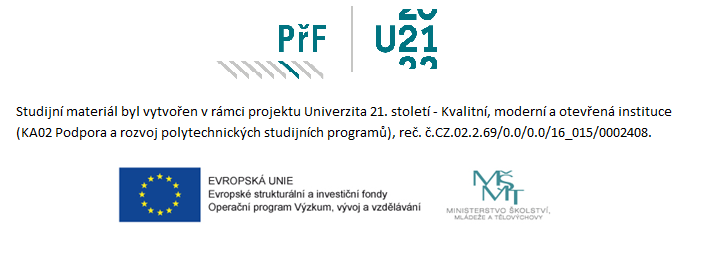

# Dimensionalita v úlohách strojového učení

V úlohách strojového učení čelíme situacím, ve kterých daný dataset má velké množství sloupců, čili máme hodně příznaků. Některé příznaky jsou pro model důležitější a některé méně. Naším cílem je na základě nějakého kritéria posoudit a vybrat jen důležité příznaky. Proč vlastně chceme vybírat jen některé důležité příznaky?

Jedním z důvodů je tzv. **prokletí dimensionality**. Obvykle máme nějaké fixní množství dat, rozuměj záznamů, a chceme, aby v tréninkových datech bylo zachyceno co nejvíce možných *variací* hodnot jednotlivých příznaků. Čím větší dimensionalita, tím větší počet variací a tím více potřebujeme dat. V podstatě klesá hustota dat s dimenzí a když ji chceme udržet konstantní, tak musíme přidávat data, což není vždy možné. Tedy např. při použití klasifikátorů počítajících vzdálenosti mezi body v příznakovém prostoru (*KNN*, *K-means*) nalezené blízké body nemusí být zas tak blízké.

Lze na to také nahlížet pohledem vyšší matematiky ([detaily zde](https://minds.wisconsin.edu/bitstream/handle/1793/60174/TR1377.pdf?sequence=1&isAllowed=y)) a zamyslet se, jaké bude rozložení bodů (příkladů pro učení) v příznakovém prostoru. Lze dokázat, např. [zde](https://en.wikipedia.org/wiki/Curse_of_dimensionality), že pokud budeme na vícerozměrném intervalu $<-1,1> \times <-1,1>\times \dots \times<-1,1>$ rovnoměrně generovat body, tak radiální distribuce bodů od středu ($(0,\dots,0)$) nebude rovnoměrná, ale vznikne zde oblast s nižší a vyšší radiální hustotou bodů.
Dle simulace na ukázce kódu níže, vidíme, že jsou zde téměř prázdné rohy dané hyperkrychle a též středová oblast má nižší hustotu. Naopak ve vzdálenosti $\sqrt{\frac{d}{3}}$, kde $d$ je dimenze problému, je hustota bodů nejvyšší. Se vzrůstající dimenzí dochází ke větší a větší koncentraci bodů v daném pásu. Pokud použijeme algoritmus typu *KNN* (a další využívající Euklidovskou metriku), tak hledáme k danému bodu $Q$ (neznámý bod který chceme klasifikovat, $Q$ jako query) další nejbližší body. S vzrůstem $d\rightarrow ∞$ budou tyto body na daném pásu, a ač se jedná o různé příklady, budou mít od bodu $Q$ stejnou vzdálenost, což je problém, protože se může jednat o body s různým labelem.

Praktický pohled na redukci dimensionality je ten, že nemusíme uchovávat rozsáhlá data v paměti, a zároveň je pak výpočet rychlejší.

Text(0.5, 1.0, 'Radialni distribuce bodu')

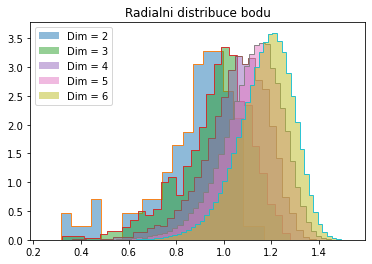

In [ ]:
# ukázka radiální distribuce náhodně generovaných bodů na intervalu <-1,1>
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

MAXD = 7 #maximalni dimenze
N = 10 # pocet generovanych bodu v dane dimenzi -generuji sit

for dim in range(2,MAXD):
  data = 2*(0.5-np.random.rand(N**dim,dim)) # preved na interva1 <-1,1> v N-D
  distance = np.sqrt(np.apply_along_axis(np.linalg.norm, 1, data)) # spocti vzdalenosti o stredu
  plt.hist(distance,bins = N*(dim), alpha=0.5, density=True, label = f"Dim = {dim}")
  plt.hist(distance,bins = N*(dim), alpha=0.9, density=True,histtype='step')
plt.legend()
plt.title("Radialni distribuce bodu")

## Použití statistiky pro redukci dimensionality

Nejjednodušší metodou redukce dimensionality je kontrola **míry variability pomocí rozptylu** $\sigma^2$ veličiny $X$:
\begin{equation}
\sigma^2 = \sum_{1}^{n}(x_i - E[X])^2 p_i,
\end{equation}
kde $n$ je počet příkladů, $E[X]$ je střední hodnota, $p_i$ představuje pravděpodobnost vzorku $x_i$ a pro případ stejné pravděpodobnosti daných hodnot volíme $p_i=1/n$.
Pro použití tak stačí odstranit ty sloupce, které mají hodnotu rozptylu nižší, než je předem definovaný *threshhold*. V knihovně *scikitlearn* je již objekt [VarianceThreshold](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold), který to řeší za nás. Před vlastním výpočtem je vhodné data převést na stejné měřítko. Zde používáme *min-max* škálování. **Proč nepoužíváme standardizaci?**

In [ ]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler


mmsc = MinMaxScaler(feature_range=[-1,1]) #defaultně <0,1>
data = load_wine()

X = pd.DataFrame(mmsc.fit_transform(data.data), columns = data.feature_names) #nacti si data
print(f"Rozměry před odstraněním sloupců {X.shape}")
sel = VarianceThreshold(threshold=0.1)
X = sel.fit_transform(X)
print(f"Rozměry po odstranění sloupců {X.shape}")

Rozměry před odstraněním sloupců (178, 13)
Rozměry po odstranění sloupců (178, 11)


**Je možné použít další nejen statistické ukazatele.**

V zásadě jde o to, že se sestaví linerání regresní model:

\begin{equation}
y \approx \beta_0 + \beta_1 x_1 + \beta_2 x_2 \ldots \beta_n x_n,
\end{equation}
kde $x_i$ jsou jednotlivé příznaky a zkoumáme vlastnosti tohoto modelu, jak který regresor vysvětluje hodnotu $y$.


*   Pearsonův korelační koeficient mezi $x_i$ a $y$, viz [zde](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.r_regression.html#sklearn.feature_selection.r_regression).
*  F-test regresorů, více viz [zde](https://timeseriesreasoning.com/contents/f-test-for-regression-analysis/). Implementováno v scikit-learn [zde](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html#sklearn.feature_selection.f_regression)
* Chi-2 testy [zde](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) , Fisher-score apod.

Podrobnější výčet je uveden [zde](https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection).



#### Úkol pro samostatnou činnost:

1.   Proveďte vlastní implementaci výše uvedeného.
2.   Vyzkoušejte na předchozím datasetu alespoň dva algoritmy uvedené [zde](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection).




## Metoda analýzy hlavních komponent - PCA

Metoda analýzy hlavních komponent - *PCA* (Principal Component Analysis) je metoda učení bez učitele, tedy nebere v potaz hodnotu labelů (příznaků). Je založena na singulárním rozkladu datasetu $X$, proto se nejprve seznámíme s metodou *SVD* (Singular Value Decomposition). Uvědomme si, že dataset $X$ je vlastně matice čísel, pokud ne, tak ji pomocí operací uvedených v sheetu **Práce s datasety** musíme nejprve vytvořit.

Cílem PCA je nalézt takové lineární zobrazení $X → X_{tr}$, že počet sloupců matice $X_{tr}$ bude menší než počet sloupců matice $X$.

**Poznámka**

Často se metoda PCA odvozuje pomocí vlastních čísel jisté matice zkonstruované z $X$, níže si to též ukážeme. Ovšem použití SVD místo výpočtu vlastních čísel a vektorů je efektivnější, viz [zde](https://intoli.com/blog/pca-and-svd/).

### Metoda SVD

Metoda *SVD* je maticová faktorizační metoda, kde se danou matici $A \in 𝖱^{n \times m}$  snažíme vyjádřit ve tvaru
\begin{equation}
A = U\Sigma V^T,
\end{equation}
kde matice $\Sigma \in 𝖱^{n \times m}$ je obdélníková *diagonální* matice s nezápornými hodnotami na diagonále, matice $U \in 𝖱^{m \times m} $ a $V\in 𝖱^{n \times n}$ jsou *ortogonální*. Ortogonálností rozumíme, že platí $U^TU = I_n$ a $V^TV = I_m$, kde $I_n$, resp. $I_m$ jsou jednotkové matice o rozměru *n*, resp. *m*.

Diagonální hodnoty $\sigma_{i}$ matice $\Sigma$ se nazývají *singulární hodnoty*. SVD rozklad, lze zapsat následujícím způsobem

\begin{equation}
  A = U\times\Sigma \times V^T =
  \underbrace{
    \begin{bmatrix}
      u_1 & u_2 & \cdots & u_n
    \end{bmatrix}
  }_{U\space(n\times n)}
  \times
  \underbrace{
    \begin{bmatrix}
      \sigma_1 & 0 & \cdots & 0 \\
      0 & \sigma_2 &  & \vdots \\
      \vdots &  & \ddots & 0 \\
      0 & \cdots & 0 & \sigma_r \\
      \vdots &  &  & 0 \\
      0 &  &  & \vdots  \\
      0 & \cdots & 0 & 0 \\
    \end{bmatrix}
  }_{\Sigma\space(n\times m)}
  \times
  \underbrace{
    \begin{bmatrix}
      v_1 \\
      v_2 \\
      \vdots \\
      v_m
    \end{bmatrix}
  }_{V^T\space(m\times m)},
\end{equation}
 kde $\sigma_1,\ldots,\sigma_r$ (kde *$r \leq \min (n, m)$*) jsou singulární čísla umístěná na diagonále matice $\Sigma$ a $v_1,\ldots ,v_m$ jsou ortonormální sloupce $V^T$.

 Výpočet *SVD* je otázkou kurzu (numerické) matematiky, poznamenejme, že tento rozklad je již implementován v knihovně *numpy* [zde](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html). V uvedené implementaci je vracená matice $\Sigma$ jen vektor $r$ singulárních čísel a proto ho musíme na matici $\Sigma$ převést. Dále je někdy výhodné, když si uvědomíme, že v součinu $U\Sigma V^T$ dochází k násobení některých řádků $U$ (nebo sloupců $V$, záleží odkud násobíme) nulovým vektorem (nulové řádky v matici $\Sigma$), tedy není nutné toto vůbec provádět a vracet matici $U$ bez příslušných sloupců.




In [ ]:
import numpy.linalg as la

A = np.random.rand(5,3)

#použití plného rozklad
U, s, Vt = np.linalg.svd(A, full_matrices=True) # pozor s neni sigma
S = np.zeros(A.shape)
r = min(A.shape)
S[:r,:r] = np.diag(s)
print(f"U:{U}")
print(f"S:{S}")
print(f"Vt:{Vt}")
print(f"Chyba: suma |A-U*S*Vt| = {np.sum(np.abs(A-np.dot(U, np.dot(S, Vt))))}")
print("*"*50)
# použití komprimovaného rozkladu
U, s, Vt = np.linalg.svd(A, full_matrices=False) # pozor s neni sigma
S = np.diag(s)
print(f"U:{U}")
print(f"S:{S}")
print(f"Vt:{Vt}")
print(f"Chyba: suma |A-U*S*Vt| = {np.sum(np.abs(A-np.dot(U, np.dot(S, Vt))))}")


U:[[-0.46084878  0.57949576 -0.59545289  0.30614249 -0.05929338]
 [-0.53464025  0.02807201  0.01580022 -0.8413216  -0.07280168]
 [-0.56928661  0.10061233  0.7221248   0.37202921  0.07694119]
 [-0.41730946 -0.80714886 -0.33066816  0.2395994  -0.08725961]
 [-0.05952967 -0.04224351 -0.11991892 -0.05139198  0.98876186]]
S:[[2.75853057 0.         0.        ]
 [0.         0.45613145 0.        ]
 [0.         0.         0.13907075]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
Vt:[[-0.66395968 -0.60658788 -0.43727415]
 [ 0.23198656 -0.72301404  0.65071724]
 [-0.71087254  0.33060829  0.62077241]]
Chyba: suma |A-U*S*Vt| = 2.5326962749261384e-15
**************************************************
U:[[-0.46084878  0.57949576 -0.59545289]
 [-0.53464025  0.02807201  0.01580022]
 [-0.56928661  0.10061233  0.7221248 ]
 [-0.41730946 -0.80714886 -0.33066816]
 [-0.05952967 -0.04224351 -0.11991892]]
S:[[2.75853057 0.         0.        ]
 [0.         0.45613145 0.        ]
 [0.   

### Aplikace SVD pro kompresi

Dříve než ukážeme metodu *PCA*, tak si nejprve ukážeme využití *SVD* při redukci dimensionality pro ztrátovou kompresi obrázku. Předpokládejme, že máme černobílý obrázek, který reprezentujeme jako matici $A$ s hodnotami od 0 do 255. Spočteme si jeho SVD $A = U\Sigma V^T$. Protože matice $\Sigma$ obsahuje sestupně setříděná singulární čísla, tak si můžeme stanovit mez, za kterou budeme považovat daná $\sigma_i$ za nulová. Dejme tomu, že těchto čísel je $r$. Dále se uvědomme, že při násobení mezi maticemi $U$ a $V$ se $\Sigma$ dojde k násobení nulových sloupců a řádků matice $\Sigma$ a výsledkem tedy bude nula. Můžeme tedy některé sloupce matice $U$ a řádky matice $V$ zanedbat. Tedy místo uložení obrázku (matice $A$), uložíme tři redukované matice $U_r, \Sigma_r, V_r$. Rekonstrukci (dekompresi) původního obrázku získáme opět jejich vynásobením. Výsledná rekonstrukce $A_r$ má stejné rozměry jako původní matice $A$.
Schematicky je to znázorněno:

\begin{equation}
\begin{array}{c}
U \\
\left[
\begin{array}{cc:ccc}
   & & & &  \\
   & & & & \\
   \mathbf{U_r} & & & & \\
   & & & & \\
   & & & & \\
   & & & & \\
\end{array}
\right] \\
\end{array}
\times
\begin{array}{c}
\Sigma \\
\left[
\begin{array}{ccc:ccc}
&&&& & \\
& \mathbf{\Sigma_r} &&&0& \\
&&&& & \\
\hdashline &&&& & \\
&0&&&0& \\
&&&&\\
\end{array}
\right] \\
\end{array}
\times
\begin{array}{c}
V^T \\
\left[
\begin{array}{ccccc}
   & & & &  \\
   & & \mathbf{V^T_r} & & \\
   & & & & \\
   \hdashline
   & & & & \\
   & & & & \\
   & & & & \\
\end{array}
\right] \\
\end{array}
=
\begin{array}{c}
A \\
\left[
\begin{array}{ccccc}
   & & & &  \\
   & & & & \\
   & & A_r & & \\
   & & & & \\
   & & & & \\
   & & & & \\
\end{array}
\right]. \\
\end{array}
\end{equation}

**Poznámka**

Uvědomme si, že opravdu dojde ke kompresi. Pokud byl obrázek rozměrů $\mathbf{n \times m}$, pak při volbě $r$ ukládáme jen $\mathbf{n \times r + r + r \times m}$ pixelů.

Při redukci dimensionality pomocí PCA postupujeme obdobně, tedy "zahazujeme" jistou část informace tím, že zanedbáváme malé singulární hodnoty. Rozdíl je ten, že naším primárním cílem není zmenšit objem dat, ale snížit dimenzi úlohy.

Na následující ukázce kódu je ukázána implementace komprese obrázku.


Saving pes.jpeg to pes.jpeg


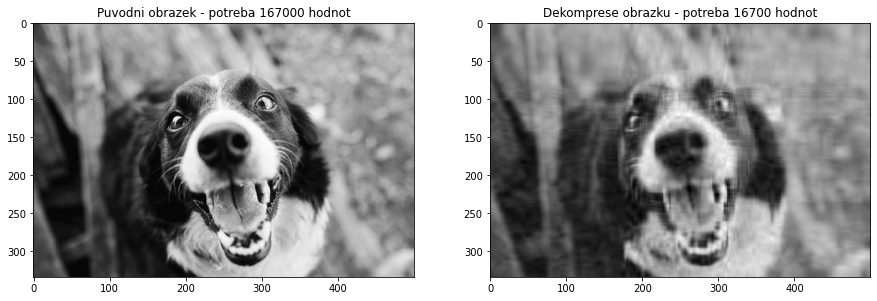

In [ ]:
# ukázka komprese
from google.colab import files
import io
from PIL import Image
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt


# mira komprese - kolik se pouzije singularnich hodnot
r= 20
# nacteni obrazku
uploaded = files.upload()
file_name = next(iter(uploaded.keys()))
A = Image.open(file_name).convert('L')
A = np.array(A) # udelej z obrazku pole
n,m = A.shape
# komprese
U, s, Vt = np.linalg.svd(A, full_matrices=False) # pozor s neni sigma
s[r:] = 0 # prepis zbyvajici hodnoty 0
S = np.diag(s) # udelej diagonalni matici
Ar = np.dot(U, np.dot(S, Vt)) # rekonstruuj

plt.rcParams['figure.figsize'] = [15, 5]
figure, axis = plt.subplots(1, 2)
axis[0].set_title(f"Puvodni obrazek - potreba {n*m} hodnot")
axis[0].imshow(A,cmap='gray')
axis[1].set_title(f"Komprimovany obrazek po dekompresi  - potreba {n*r+r+m*r} hodnot")
axis[1].imshow(Ar,cmap='gray')

###Princip PCA

Nejprve si vysvětlíme použití PCA pomocí vlastních čísel a vektorů matic.

Předpokládejme, že jsme data jednotlivých sloupců matice $X\in R^{n,m}$ nejprve centrovali kolem průměru. Stačí od hodnoty v *i-tém*  sloupci odečíst jeho průměr $\mu_i$. Pokud jsou měřítka jednotlivých sloupců odlišná, pak matici $X$ i škálujeme.  Zkonstrujeme-li matici $S$ pomocí vzorce
\begin{equation}
S = \frac{1}{n-1}X^TX,
\end{equation}
kde $n$ je počet řádků, tak vidíme, že matice $S\in R^{m,m}$ je [maticí kovariance](https://cs.wikipedia.org/wiki/Kovarian%C4%8Dn%C3%AD_matice). Chceme nalézt takové vzájemně ortonormální směry $v_i$, ve kterých je kovariance maximální, viz obrázek níže.


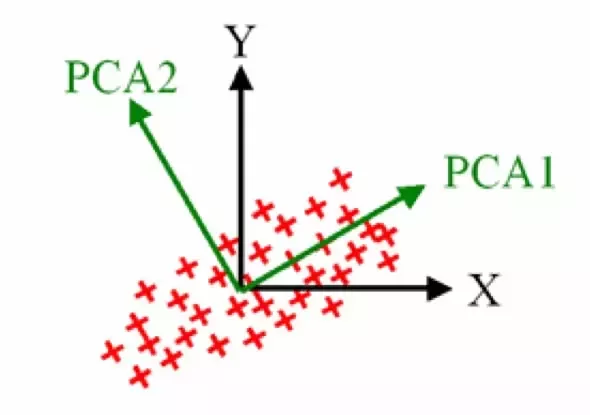

Převzato z webu [quora.com](https://www.quora.com/What-is-principal-component-analysis-and-how-many-variables-can-be-used-for-PCA)


Výběr směru ve kterém je kovariance maximální vede na maximalizaci kvadratické formy $v^TSv$, kde uvažujeme, že $v$ má délku 1. Označíme-li toto maximum jako $\lambda$, dostáváme jednoduchým přepsáním rovnici pro definici vlastních čísel $\lambda_i$ a vlastních vektorů $v_i$
\begin{equation}
S v_i = \lambda_i v_i,
\end{equation}
vektorový zápis je:
\begin{equation}
S V = V \Lambda ,
\end{equation}
kde $\Lambda$ je diagonální matice $diag(\lambda_1,\ldots,\lambda_m)$ a matice $V$ má sloupce tvořeny z vlastních vektorů $v_i$.
Vlastní čísla $\lambda_i$ nám tedy udávají míru kovariance v daném směru $v_i$. Protože $S$ je symetrická matice, tak její vlastní čísla jsou reálná, viz [theorem 1](http://www.quandt.com/papers/basicmatrixtheorems.pdf) . Nyní setřídíme vlastní čísla dle velikosti a vezmeme-li prvních $r < m$ největších vlastních čísel a jim příslušející vlastní vektory $v_1,\ldots, v_r$ uspořádáme do matice $W$.

Maticové násobení $XW$ má ten význam, že provádí projekci jednotlivých řádků, *m-dimensionálních vektorů*, matice $X$ do směrů $v_i$, tedy promítáme vektory z prostoru dimense $m$ do prostoru dimense $r < m$. Na následující ukázce kódu je ukázána tato implementace. Jedná se o volnou úpravu kódu z [Python Machine Learning, 3rd Edition](https://sebastianraschka.com/books/#python-machine-learning-3rd-edition). Pro výpočet je použita funkce [np.eig](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html). Všimněme si, že při použití pouze dvou největších vlastních čísel, je vysvětleno cca 60% celkové variability.

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Transformované body ve 2D příznakovém prostoru')

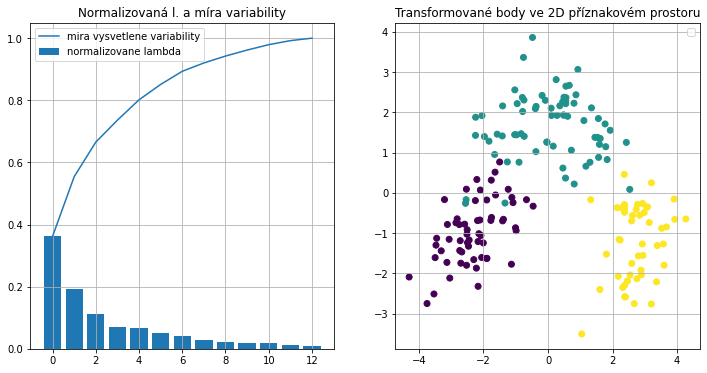

In [ ]:
# implementace PCA pomocí vlastních čísel matice
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data.data, columns = data.feature_names) #nacti si data
y = data.target# nacti si labely

n = X.shape[0]
X =(X-np.mean(X))/X.std()# centruj a naškáluj=standardizace
S = np.dot(X.transpose(), X)/(n-1)
# spoctu a sparuji dvojice vlastni cislo a vl. vektor
l,v = la.eig(S)
pairs_l_v = [ (np.abs(l[i]),v[:,i]) for i in range(len(l))] # vraci sparovane vlastni cisla a vektory
# setrid dle velikosti
pairs_l_v.sort(reverse=True)
total_l=sum(l)
sorted_l_norm = [l/total_l for l,v in pairs_l_v]# normalizovane hodnoty
sorted_v = [v for l,v in pairs_l_v]
# transformace do 2D -
# A] protoze ve 2D priznaky se dobre vizualizuji
# B] pouzitim dvou transformovanych priznaku vysvetlime 60% variability
# Pouziji tedy jen dva vlastni vektory prislusnym prvnim dvema nejvetsim vl. cislum
W = np.array((sorted_v[0], sorted_v[1])).transpose()
X_tr_eig = np.dot(X,W) # vlastni transformace z 13D do 2D
plt.rcParams['figure.figsize'] = [12, 6]
figure, axis = plt.subplots(1, 2)
axis[0].bar([i for i in range(len(sorted_l_norm))],sorted_l_norm, label = 'normalizovane lambda')
axis[0].plot([i for i in range(len(sorted_l_norm))], np.cumsum(sorted_l_norm), label = 'mira vysvetlene variability')
axis[0].grid()
axis[0].legend()
axis[0].set_title("Normalizovaná l. a míra variability")

axis[1].scatter(X_tr_eig[:,0], X_tr_eig[:,1], c = y)
axis[1].grid()
axis[1].legend()
axis[1].set_title("Transformované body ve 2D příznakovém prostoru")

### Použijeme SVD

Použijeme-li *SVD*, tak aplikací na výpočet matice $S$ dostáváme:
\begin{equation}
S = \frac{X^TX}{n-1}=\frac{(U\Sigma V^T)^TU\Sigma V^T}{n-1}=\frac{V\Sigma^TU^TU\Sigma V^T}{n-1}=\frac{V\Sigma^2V^T}{n-1},
\end{equation}
což můžeme přepsat do tvaru:
\begin{equation}
SV = \frac{V\Sigma^2}{n-1},
\end{equation}
což je rovnice odpovídající vektorovému zápisu vlastních čísel s tím rozdílem, že zde máme matici tvořenou singulárními hodnotami ve druhé mocnině $\Sigma^2$ a jistou konstantou $n-1$. Vztah mezi vlastními čísly $\lambda_i$ matice $S$ a singulárními hodnotami je $\sigma_i^2 = (n-1)\lambda_i$.
Protože SVD nám již poskytuje setříděná singulární čísla, tak stačí jen zanedbat hodnoty $\sigma_i$ menší než nějaké zvolená hladina. Nebo když kumulativní součet dosáhne jisté hladiny.

Transformační matici $W$ získáme tak, že použijeme příslušné sloupce matice $V$ z rozkladu *SVD*. Detaily vztahů mezi oběma způsoby lze nalézt [zde](https://intoli.com/blog/pca-and-svd/).

Níže v ukázce kódu vidíme, že implementace *PCA* pomocí *SVD* je poměrně přímočará.


No handles with labels found to put in legend.


Text(0.5, 1.0, 'Transformované body ve 2D příznakovém prostoru')

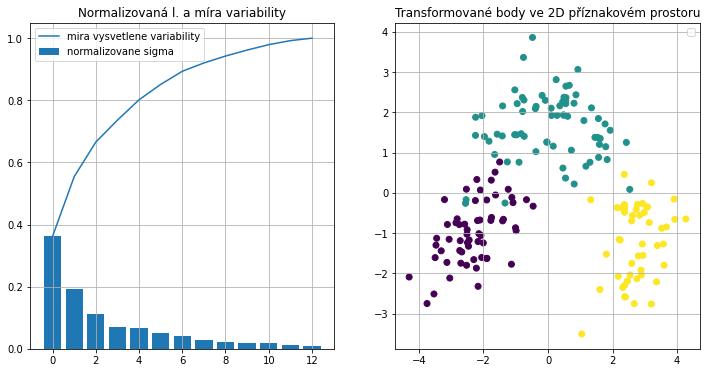

In [ ]:
# implementace PCA pomocí SVD dekompozice
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
data = load_wine()
X = pd.DataFrame(data.data, columns = data.feature_names) #nacti si data
y = data.target# nacti si labely

n = X.shape[0]
X =(X-np.mean(X))/X.std()# centruj a naškáluj=standardizace
S = np.dot(X.transpose(), X)/(n-1)
U, s, Vt = np.linalg.svd(S, full_matrices=False) # pozor s neni sigma
s_norm=s/sum(s)
W = Vt.transpose()[:,:2]
X_tr_svd=np.dot(X,W)

plt.rcParams['figure.figsize'] = [12, 6]
figure, axis = plt.subplots(1, 2)
axis[0].bar([i for i in range(len(s_norm))],s_norm, label = 'normalizovane sigma')
axis[0].plot([i for i in range(len(s_norm))], np.cumsum(s_norm), label = 'mira vysvetlene variability')
axis[0].grid()
axis[0].legend()
axis[0].set_title("Normalizovaná l. a míra variability")

axis[1].scatter(X_tr_svd[:,0], X_tr_svd[:,1], c = y)
axis[1].grid()
axis[1].legend()
axis[1].set_title("Transformované body ve 2D příznakovém prostoru")

### PCA prakticky

V knihovně *sklearn* je již metoda [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) naimplementována. Dle dokumentace nedochází ke standardizaci datasetu, nýbrž pouze k jeho centrování (odečtení průměru). Z důvodu porovnání byl dataset standardizován.

**Poznámka**
Pokud se pozorněji podíváte na obrázek datasetu po *PCA* transformaci, tak zjistíte, že je zrcadlově otočený vůči předchozím dvěma.
Důvod je ten, že vlastní vektory jsou určeny jednoznačně až na multiplikativní nenulovou konstantu, třeba $-1$.
Porovnejme si obě následující rovnice:
\begin{equation}
Av=\lambda v  
\end{equation}
a
\begin{equation}
Au=\lambda u,
\end{equation}
kde když bude $u=-v$, tak je též splněna. Tedy v různých implementacích metody *PCA* mohou být v podstatě otočené hlavní osy.

No handles with labels found to put in legend.


[28.86062187 21.0229482 ]


Text(0.5, 1.0, 'Transformované body ve 2D příznakovém prostoru')

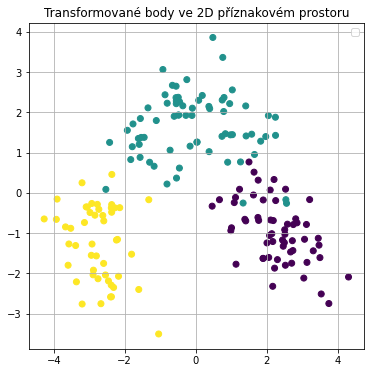

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
# nacteni datasetu viz vyse
data = load_wine()
X = pd.DataFrame(data.data, columns = data.feature_names) #nacti si data
y = data.target# nacti si labely

X =(X-np.mean(X))/X.std()# centruj a naškáluj=standardizace
# pouziti PCA
pca = PCA(n_components=2)
X_tr_pca = pca.fit_transform(X)
# kresleni grafu
plt.rcParams['figure.figsize'] = [6, 6]
plt.scatter(X_tr_pca[:,0], X_tr_pca[:,1], c = y)
plt.grid()
plt.legend()
plt.title("Transformované body ve 2D příznakovém prostoru")

#### Pokyny pro samostatnou činnost

Někdy není lineární transformace použitá v *PCA* dostačující, data nejsou rozumně separabilní. Z tohoto důvodu je možné použít nelineární *PCA*, kde se data nejprve transformují pomocí nelineárních transformaci, tzv. *kernelů* (jader). Více o nich uslyšíme u metody **SVM** v příslušném sheetu.

Seznamte se s použitím *kernelizované* PCA [zde](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py).

## Lineární diskriminační analýza - LDA
Lineární diskriminační analýza (LDA) je metoda redukce dimensionality, která využívá labelů datasetu a jedná se tedy o učení s učitelem. Za odvozením se skrývá komplikovanější matematika. Základní myšlenkové obraty jsou uvedeny [zde](https://ml-explained.com/blog/linear-discriminant-analysis-explained) a [zde](https://www.geeksforgeeks.org/ml-linear-discriminant-analysis/).

Základní myšlenka spočívá v tom, najít souřadnicovou osu (na obrázku vlevo níže, červená), takovou, že když na ní provedeme projekci datových bodů tak, že

**A**)   vzdálenost mezi těžišti je maximální,

**B**)   variance v rámci každé třídy je minimální.




Nová souřadnicová osa | Projekce bodů na osu
-|-
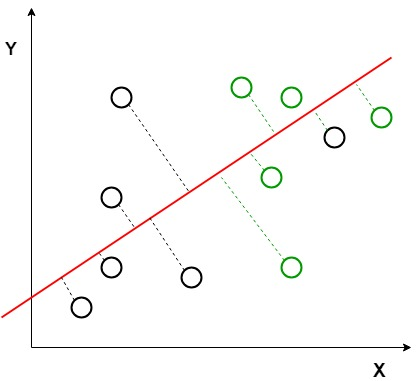 | 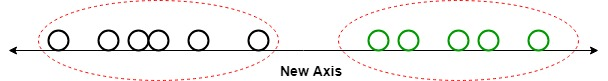

Zdroj obrázků: https://www.geeksforgeeks.org/ml-linear-discriminant-analysis/

###LDA - matematika pro binární úlohu
*Níže uvedené je spíše pro pochopení principu. Některé věci jsou zde udělány pouze schematicky. Zaměřte se spíše na princip, než na detailní odvození.*

Označme $C_0$ a $C_1$ množiny datových bodů, které přísluší jednotlivým třídám (máme binární úlohu), počty datových bodů v daných množinách označujeme $\#C_0$ a $\#C_1$. Těžište každé třídy v daném *m-dimensionálním* prostoru spočteme
\begin{equation}
\mu_0 = \frac{\sum_{x_i \in C_0}x_i}{\#C_0} \;\mbox{a}\;\mu_1 = \frac{\sum_{x_i \in C_1}x_i}{\#C_1}.
\end{equation}
Projekce těchto těžišť do směru osy $v$, kterou ovšem neznáme, označme $\hat{\mu}_0 = v^T\mu_0$ a $\hat{\mu}_1 = v^T\mu_1$.
Chceme maximalizovat vzdálenost mezi těžišti po projekci, tedy $\max |\hat{\mu}_0 -\hat{\mu}_1|$ a zároveň minimalizovat rozptyl (varianci) v rámci každé třídy
 \begin{equation}
\sigma^2_0=\sum_{x_i\in C_0}(v^Tx_i-\hat{\mu}_0)^2
\end{equation}
 a
 \begin{equation}
 \sigma^2_1=\sum_{x_i\in C_1}(v^Tx_i-\hat{\mu}_1)^2
 \end{equation} opět po projekci.
 Což vede k následující úloze maximalizace funkce $J(v)$  
 \begin{equation}
 \max_{v \in R^m}J(v)=\max_{v \in R^m}\frac{|\hat{\mu}_0 -\hat{\mu}_1|}{\sigma^2_0+\sigma^2_1},
 \end{equation}
 neboť chceme co největší čitatel a nejmenší jmenovatel.

Pro zjednodušení výrazu zavedeme následující matice:
\begin{align}
&S_0 = \sum_{x_i\in C_0}(x_i-\mu_0)(x_i-\mu_0)^T\\
&S_1 = \sum_{x_i\in C_1}(x_i-\mu_1)(x_i-\mu_1)^T\\
&S_w = S_0+S_1\\
&S_b = (\mu_0-\mu_1)(\mu_0-\mu_1)^T,
\end{align}
kde matice $S_w$ reprezentuje varianci uvnitř tříd (*within*) a matice $S_b$ reprezentuje varianci (*between*) mezi třídami. Pro použití *LDA* na úlohu s více třídami se matice $S_b$ definuje mírně odlišně, viz dále.

Výše uvedenou úlohu lze pak přepsat, viz [zde](https://www.geeksforgeeks.org/ml-linear-discriminant-analysis/), na tvar:
\begin{equation}
\max_{v \in R^m}J(v)=\max_{v \in R^m}\frac {v^TS_bv}{v^TS_wv}.
\end{equation}
Pro nalezení maxima (podezřelý bod) řešíme rovnice $\nabla_{v}J(v)=0$ a úpravou dostáváme:
\begin{equation}
S_bv-\lambda(v) S_w v=0,\;\mbox{kde}\; \lambda(v)=\frac{v^TS_bv}{v^TS_wv}.
\end{equation}
Toto lze přepsat na úlohu podobnou úloze s hledáním vlastních čísel:
\begin{equation}
S_w^{-1}S_bv = \lambda(v) v.
\end{equation}
V dalším už se postupuje obdobně k metodě *PCA* jen s tím rozdílem, že místo matice $S$ je použita matice $S_w^{-1}S_b$. V případě úlohy s $K$ třídami je formulace obdobná, ale matice $S_W$ vzniká součtem matic $S_i, i=0,1,\ldots,K$, další změna je při výpočtu matice $S_b$, viz např. [zde](https://www.researchgate.net/publication/316994943_Linear_discriminant_analysis_A_detailed_tutorial)


Nebudeme zde *LDA* programovat, ale ukážeme si použití její implementace z knihovny [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html).

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Transformované body ve 2D příznakovém prostoru')

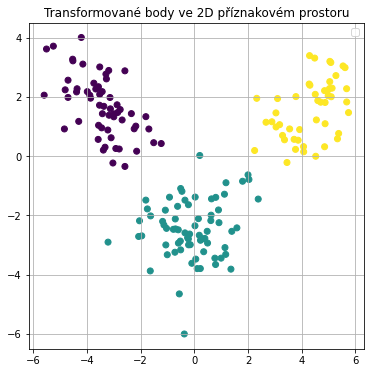

In [ ]:
# použití LDA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_wine
# nacteni datasetu viz vyse
data = load_wine()
X = pd.DataFrame(data.data, columns = data.feature_names) #nacti si data
y = data.target# nacti si labely

lda = LinearDiscriminantAnalysis(n_components=2)
X_tr_lda = lda.fit_transform(X,y)

plt.rcParams['figure.figsize'] = [6, 6]
plt.scatter(X_tr_lda[:,0], X_tr_lda[:,1], c = y)
plt.grid()
plt.legend()
plt.title("Transformované body ve 2D příznakovém prostoru")

#### Úkoly pro smostatnou činnost

Ověřte jak použití metod *PCA* a *LDA* ovlivní úspěšnost klasifikace pomocí logistické regrese pro *wine data set*. Vyzkoušejte vliv počtu komponent.

# Další projekční metody

Jako další projekční metody je možné uvažovat t-SNE, viz [zde](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), které je možné použít v rámci knihovny scikit-learn [zde](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), či metodu [UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html).

# Literatura:
1) [Blog](https://sebastianraschka.com/blog/2021/ml-course.html) autora knihy [Python Machine Learning, 3rd Edition](https://sebastianraschka.com/books/#python-machine-learning-3rd-edition):

RASCHKA, Sebastian a Vahid MIRJALILI. Python machine learning: machine learning
and deep learning with Python, scikit-learn, and TensorFlow. Birmingham: Pack pub-
lishing, 2017. ISBN 978-1-78712-593-3.

2)  Pro čtenáře s hlubším zájmem je k dispozici sbírka výukových materiálů ke knize [An Introduction to Statistical Learning](https://www.statlearning.com/) včetně
knihy samotné:

JAMES, Gareth, Daniela WITTEN, Trevor HASTIE a Robert TIBSHIRANI. An introduction to statistical learning: with applications in R. New York: Springer, [2013]. Springer texts in statistics, 103. ISBN 978-1461471370.

